### Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

# metadata
print(breast_cancer_wisconsin_original.metadata)

# variable information
print(breast_cancer_wisconsin_original.variables)


{'uci_id': 15, 'name': 'Breast Cancer Wisconsin (Original)', 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original', 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv', 'abstract': 'Original Wisconsin Breast Cancer Database', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 699, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': ['Sample_code_number'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1990, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5HP4Z', 'creators': ['WIlliam Wolberg'], 'intro_paper': None, 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, having been removed fro

### Digging into the features

In [4]:
X.describe()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


### Specifying features nan

In [5]:
nan_sum_X = X.isnull().sum()
nan_sum_X

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
dtype: int64

### Counting the different values of the feature that has nan

In [6]:
X['Bare_nuclei'].value_counts()

Bare_nuclei
1.0     402
10.0    132
2.0      30
5.0      30
3.0      28
8.0      21
4.0      19
9.0       9
7.0       8
6.0       4
Name: count, dtype: int64

### Deleting rows that have nan

In [7]:
X = X[pd.to_numeric(X['Bare_nuclei'], errors='coerce').notnull()]
X["Bare_nuclei"] = X["Bare_nuclei"].astype(int)

<ipython-input-7-b01b9d592394>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Bare_nuclei"] = X["Bare_nuclei"].astype(int)


### Identical rows in the target data should also be deleted

In [8]:
indices_to_keep = X.index
y = y.loc[indices_to_keep]

### Specifying the type of features

In [9]:
X.dtypes

Clump_thickness                int64
Uniformity_of_cell_size        int64
Uniformity_of_cell_shape       int64
Marginal_adhesion              int64
Single_epithelial_cell_size    int64
Bare_nuclei                    int64
Bland_chromatin                int64
Normal_nucleoli                int64
Mitoses                        int64
dtype: object

### Specifying target nan

In [10]:
nan_sum_y = y.isnull().sum()
nan_sum_y

Class    0
dtype: int64

### Counting the different values of the target

In [11]:
y.value_counts()

Class
2        444
4        239
Name: count, dtype: int64

### Changing the target label to 0 and 1

In [12]:
y['Class'] = y['Class'].replace({2: 0, 4: 1})

### Drawing histogram of features

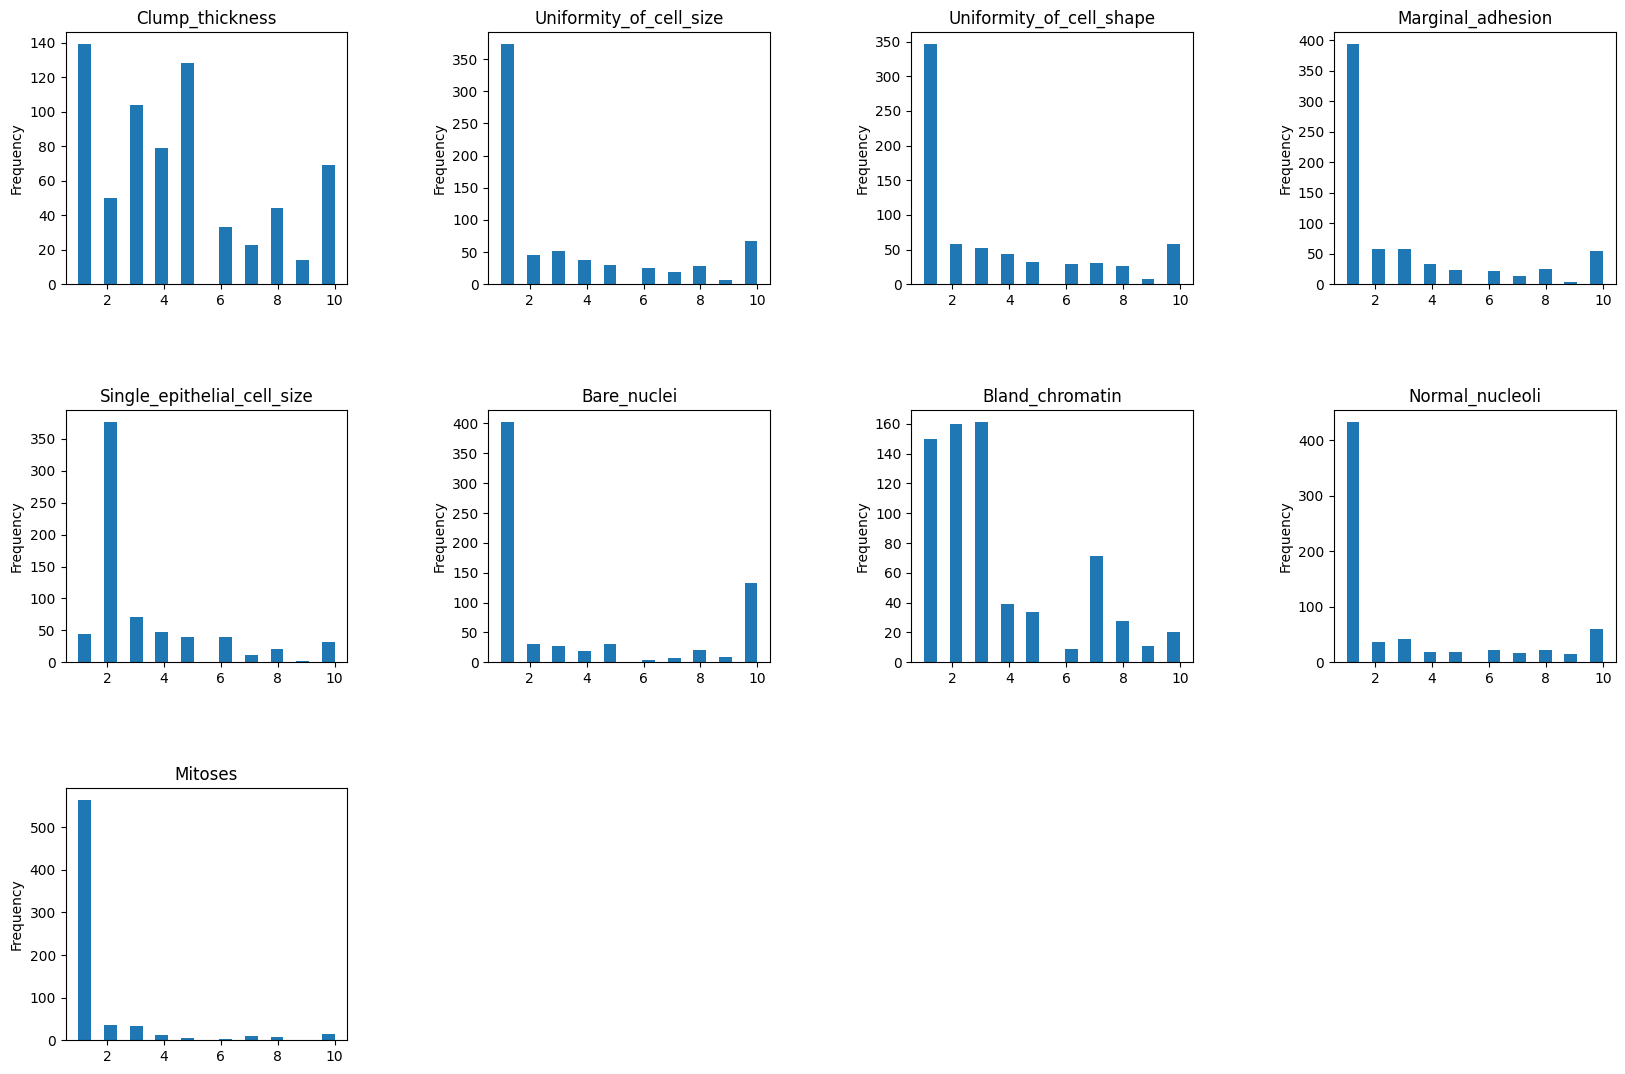

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, column in enumerate(X.columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    X[column].plot.hist(ax=ax, bins=20)
    ax.set_title(column)

if len(X.columns) < 16:
    for i in range(len(X.columns), 16):
        row = i // 4
        col = i % 4
        fig.delaxes(axes[row, col])

plt.show()

### Drawing heatmap features

<Axes: >

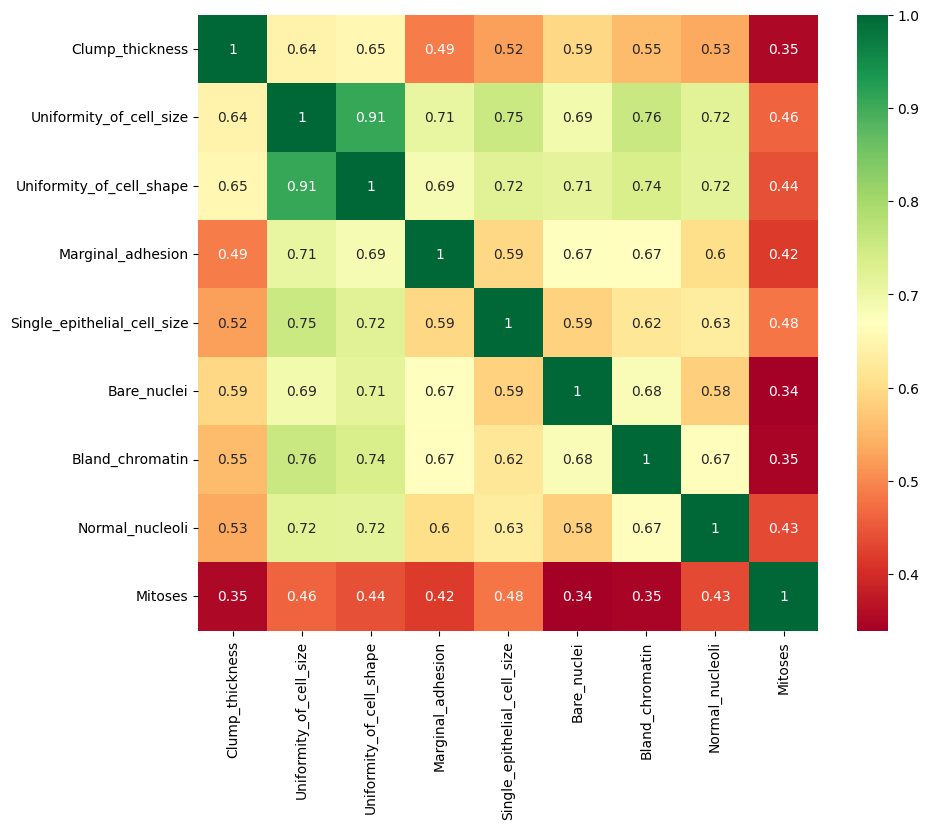

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='RdYlGn')

### Converting features and targets into array

In [15]:
x = np.asarray(X)
y = np.asarray(y['Class'])

### Separation of training and test data/Convert labels to categorical

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

# Convert labels to categorical
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=2)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=2)

print('Train set:', x_train.shape, y_train_categorical.shape)
print('Test set:', x_test.shape, y_test_categorical.shape)

Train set: (546, 9) (546, 2)
Test set: (137, 9) (137, 2)


### Define early stopping

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

### Model design and model training

In [18]:
model = Sequential([
    Dense(units=25, activation='relu'),
    Dense(units=15, activation='relu'),
    Dense(units=10, activation='linear')
])
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True))
model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])
logits = model(x_train)
f_x = tf.nn.softmax(logits)

Epoch 1/100
14/14 [==============================] - 1s 20ms/step - loss: 3.6264 - val_loss: 2.6026
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 2.2161 - val_loss: 1.7683
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1.6194 - val_loss: 1.4032
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 1.2990 - val_loss: 1.1546
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0680 - val_loss: 0.9566
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.8825 - val_loss: 0.7888
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.7258 - val_loss: 0.6532
Epoch 8/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6090 - val_loss: 0.5485
Epoch 9/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5160 - val_loss: 0.4815
Epoch 10/100
14/14 [==============================] - 0s 5ms/step - loss: 0.4450 - val_loss: 0.4101
Epoch 11

### Computing accuracy of the model

In [19]:
# Obtain predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute accuracy
accuracy = np.mean(y_pred == y_test)

print('Test accuracy:', accuracy)

5/5 [==============================] - 0s 3ms/step
Test accuracy: 0.9927007299270073


### Plotting the confusion matrix

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.98      1.00      0.99        47

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137



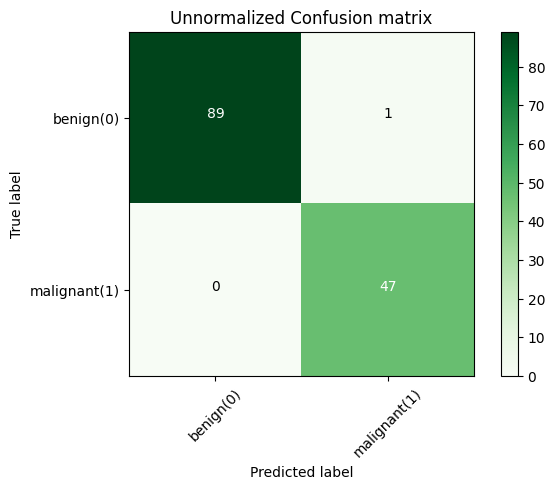

In [20]:
def plot_confusion_matrix(confusion_matrix, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Greens):
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    else:
        title = 'Unnormalized ' + title

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['benign(0)','malignant(1)'], normalize=False, title='Confusion matrix')
